In [1]:
# import things
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

In [2]:
# REQUIREMENT: Do not add code from Tasks 2 or 4
# REQUIREMENT: All dataset prep (crop/pad/patch/directory structure) must be finalize before attempting this task.
patch_size = 256
patch_dir = r"C:\Users\batkm\Desktop\Year2BlockB\Datasets\combined_patched_dataset_v6"


In [3]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
# Define U-Net
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1])
    model.summary()
    
    return model

In [5]:
# Build U-Net
# REQUIREMENT: Model summary must be visible
model = simple_unet_model(patch_size, patch_size, 3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [6]:
# Training images
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='rgb',
    shuffle=True,  # Enables shuffling of files
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator()

train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    shuffle=True,  # Enables shuffling of files
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

Found 156555 images belonging to 1 classes.
Found 156555 images belonging to 1 classes.


In [7]:
# val images
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='rgb',
    shuffle=True,  # Enables shuffling of files
    seed=42
)

# Training masks
val_mask_datagen = ImageDataGenerator()

val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    shuffle=True,  # Enables shuffling of files
    seed=42
)

val_generator = zip(val_image_generator, val_mask_generator)

Found 32634 images belonging to 1 classes.
Found 32634 images belonging to 1 classes.


##### Quick test

Image batch shape: (32, 256, 256, 3)
Mask batch shape: (32, 256, 256, 1)


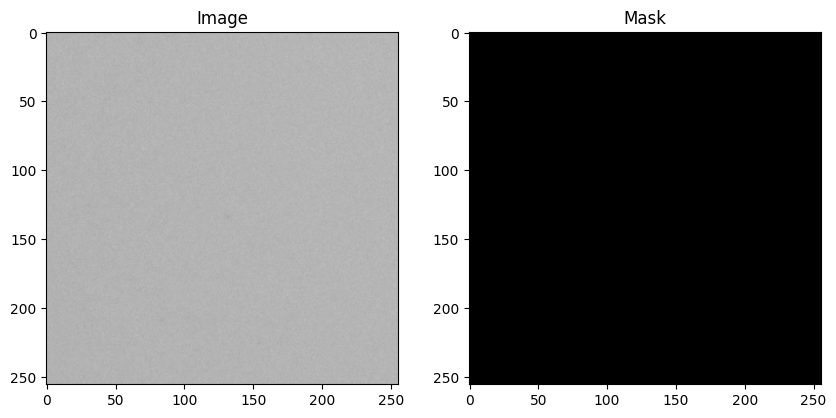

In [8]:
x_batch, y_batch = next(train_generator)

print(f"Image batch shape: {x_batch.shape}")  # Should be (16, 256, 256, 3)
print(f"Mask batch shape: {y_batch.shape}")  # Should be (16, 256, 256, 1)

# Visualize a single image and mask from the batch
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x_batch[0])  # Display the first image in the batch
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(y_batch[0].squeeze(), cmap='gray')  # Display the corresponding mask
plt.title("Mask")
plt.show()


In [9]:
# EarlyStopping()
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
cb = EarlyStopping(monitor='val_f1', patience=12, mode='max', restore_best_weights=True)



In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Device: ", tf.test.gpu_device_name())


Num GPUs Available:  1
GPU Device:  /device:GPU:0


In [11]:
# This is where the magic happens
# REQUIREMENT: The epoch logs must be visible showing validation loss and validation f1.
with tf.device('GPU:0'):
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_image_generator),
        validation_data=val_generator,
        validation_steps=len(val_image_generator),
        epochs=50,
        callbacks=[cb],
        verbose=1
    )
 

Epoch 1/50
4893/4893 [==============================] - 1164s 236ms/step - loss: 0.0131 - f1: 0.5767 - val_loss: 0.0078 - val_f1: 0.7488
Epoch 2/50
4893/4893 [==============================] - 1162s 237ms/step - loss: 0.0055 - f1: 0.7797 - val_loss: 0.0067 - val_f1: 0.7854
Epoch 3/50
4893/4893 [==============================] - 1146s 234ms/step - loss: 0.0050 - f1: 0.7972 - val_loss: 0.0067 - val_f1: 0.7820
Epoch 4/50
4893/4893 [==============================] - 1154s 236ms/step - loss: 0.0047 - f1: 0.8067 - val_loss: 0.0067 - val_f1: 0.7822
Epoch 5/50
4893/4893 [==============================] - 1145s 234ms/step - loss: 0.0046 - f1: 0.8127 - val_loss: 0.0062 - val_f1: 0.8043
Epoch 6/50
4893/4893 [==============================] - 1142s 233ms/step - loss: 0.0045 - f1: 0.8165 - val_loss: 0.0062 - val_f1: 0.8084
Epoch 7/50
4893/4893 [==============================] - 1158s 237ms/step - loss: 0.0044 - f1: 0.8181 - val_loss: 0.0064 - val_f1: 0.7976
Epoch 8/50
4893/4893 [===================

KeyboardInterrupt: 

In [ ]:
# REQUIREMENT: Save your model, it is a deliverable
# REQUIREMENT: naming convention 'studentname_studentnumber_unet_model_patchsizepx.h5'
example_file_name = f'michal_232079_unet_model_v6_{patch_size}px.h5'
print(example_file_name)
model.save(example_file_name)

michal_232079_unet_model_v6_256px.h5


In [61]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.006385283078998327
Best validation f1: 0.7780858278274536


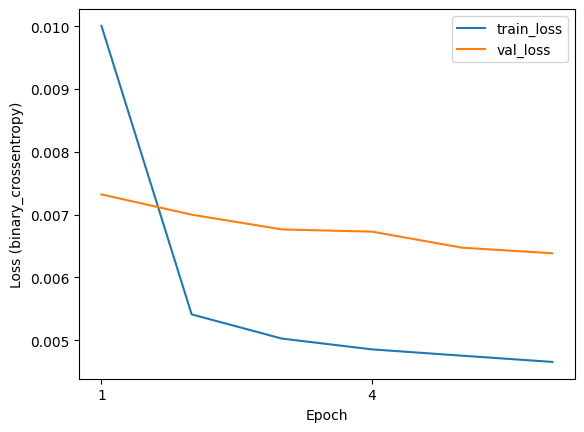

In [ ]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(loss) + 1)

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

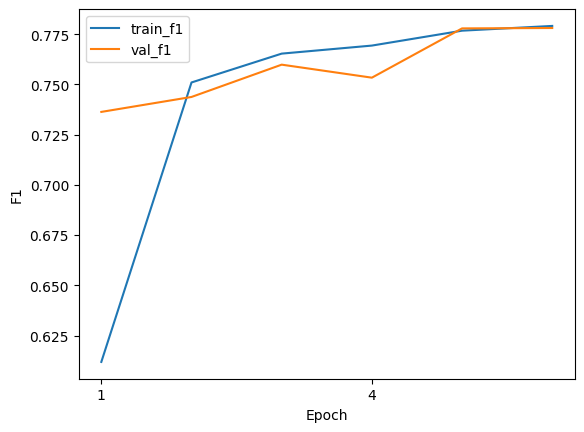

In [ ]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
train_f1 = history.history['f1']
val_f1 = history.history['val_f1']

epochs = np.arange(1, len(train_f1) + 1)

plt.plot(epochs, train_f1, label='train_f1')
plt.plot(epochs, val_f1, label='val_f1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))